# Math 86 Final Project

## Comparing AMM's

### Alex Craig, Wanxin Hu, Ganqi Li, Fangzhou Yu

## Part 1. Simple AMM

The simple AMM follows the model $xy = k$, where $k$ remains constant assuming no liquidity is provided or removed. Let's instantiate a simple AMM and see how it behaves.

### 1.1 Simple AMM Price Curve

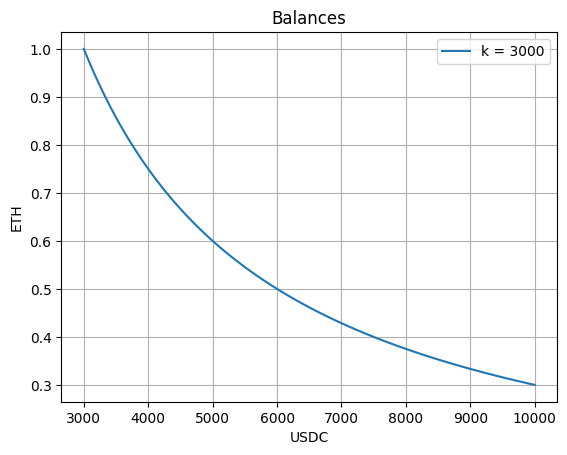

In [166]:
from simulations.simple import Simple
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

initial_x = 3000
initial_y = 1

delta = 1
x_max = 10000

simple = Simple(initial_x, initial_y)

simple_balances = [[simple.x, simple.y]]


while simple.x < x_max:
    simple.swap_x_for_y(delta)
    simple_balances.append([simple.x, simple.y])

# Plot the balances
simple_balances = np.array(simple_balances)
plt.plot(simple_balances[:, 0], simple_balances[:, 1])
plt.title("Balances")
plt.xlabel("USDC")
plt.ylabel("ETH")
plt.grid()
plt.legend(["k = " + str(simple.k)])

plt.show()

### 1.2 Simple AMM IL Curve

In [167]:
def calculate_impermanent_loss(new_price_ratio, initial_price_ratio = 1):
    price_ratio_change = new_price_ratio / initial_price_ratio
    il = 2 * (price_ratio_change ** 0.5) / (1 + price_ratio_change) - 1
    return il * 100  # Return IL as a percentage

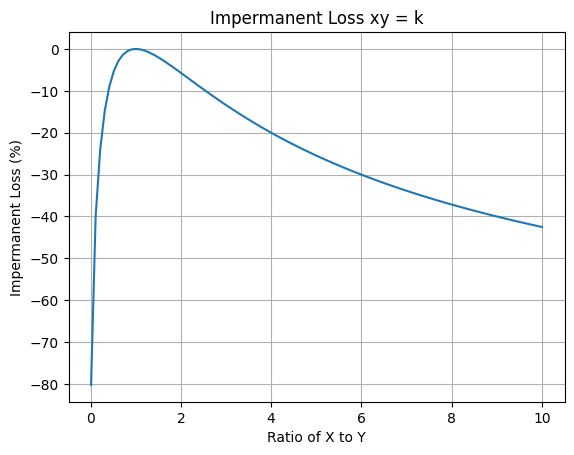

In [168]:
# Sample ratios
ratios_simple = np.linspace(0.01, 10, 100)

# Calculate the impermanent loss
impermanent_losses_simple = [calculate_impermanent_loss(r) for r in ratios]

# Plot the impermanent loss
plt.plot(ratios, impermanent_losses)
plt.title('Impermanent Loss xy = k')
plt.xlabel('Ratio of X to Y')
plt.ylabel('Impermanent Loss (%)')
plt.grid()
plt.show()

## Part 2. Balancer

Let's plot the price curve of balancer with different weights.

### 1.1 Balancer Price Curves

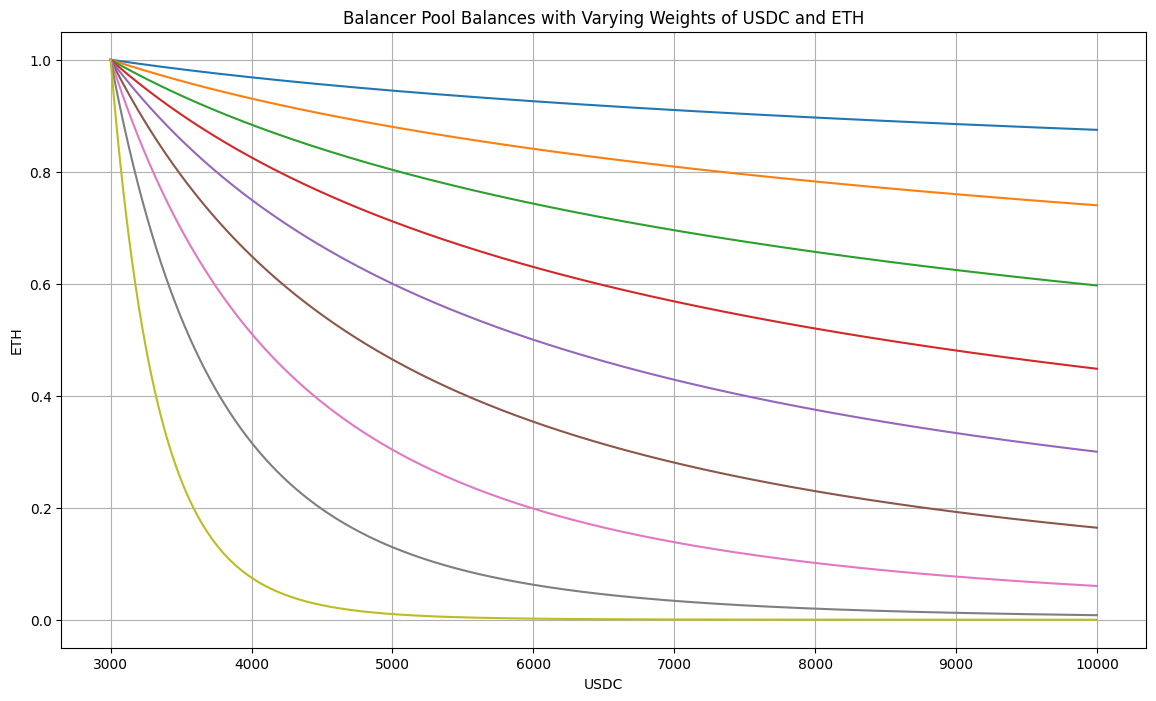

In [169]:
# Initialize variables
weights = np.arange(0.1, 1.0, 0.1)  # Weights
delta = 1
balances_by_weight = []

# Loop over each weight configuration
for weight_x in weights:
    weight_y = 1 - weight_x
    balancer = Balancer(initial_x, initial_y, weight_x, weight_y)
    balances = [[balancer.x, balancer.y]]
    
    while balancer.x < x_max:
        balancer.swap_x_for_y(delta)
        balances.append([balancer.x, balancer.y])
    
    balances_by_weight.append(np.array(balances))

# Plot the price curves for different weights
plt.figure(figsize=(14, 8))

for i, balances in enumerate(balances_by_weight):
    plt.plot(balances[:, 0], balances[:, 1], label=f'Weight x: {weights[i]*100:.0f}%')

plt.title('Balancer Pool Balances with Varying Weights of USDC and ETH')
plt.xlabel('USDC')
plt.ylabel('ETH')
plt.grid()
plt.legend
plt.show()

### 1.2.1 Balancer IL Curves Linear Scale

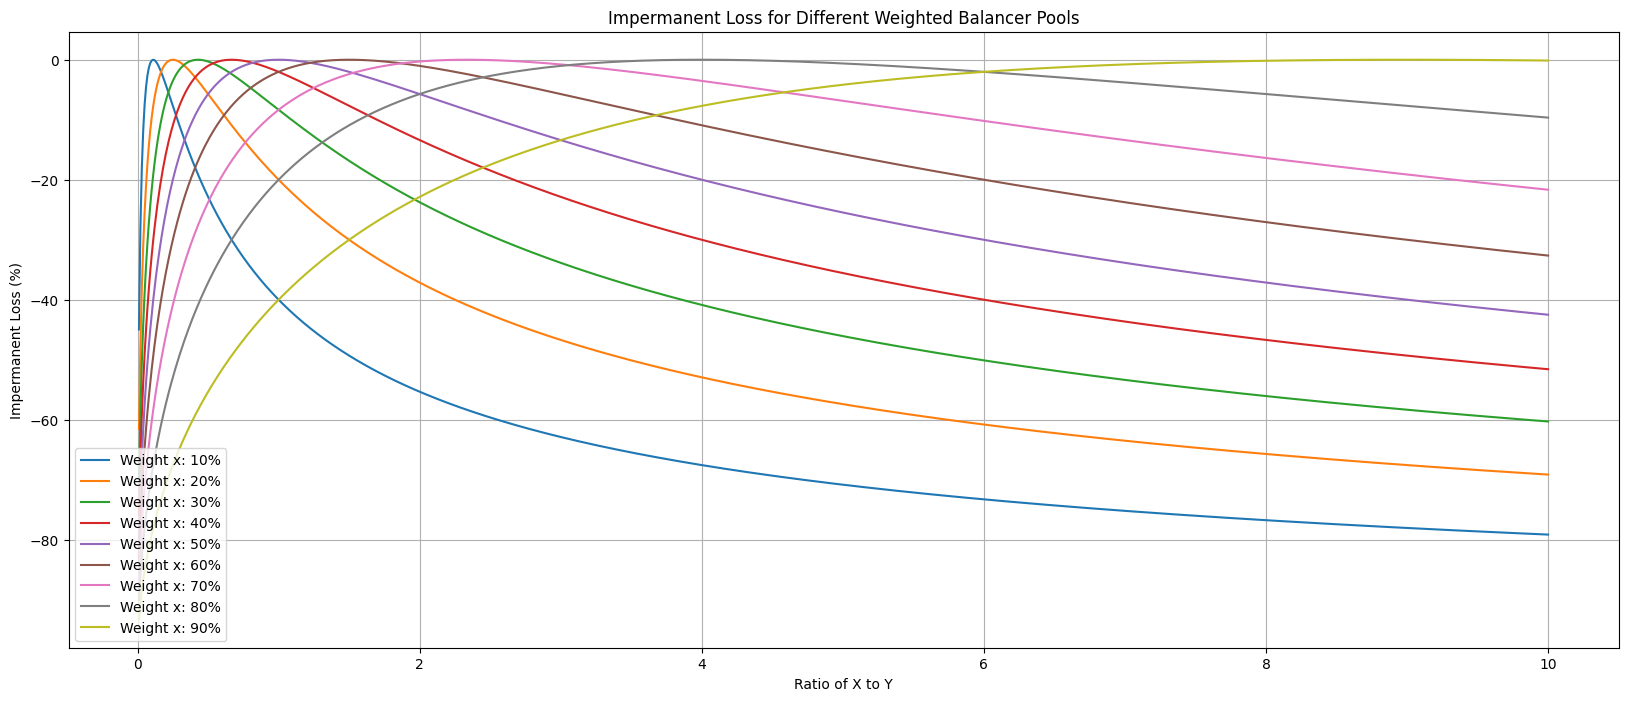

In [170]:
# Define weight configurations for Balancer pools
weights = np.arange(0.1, 1.0, 0.1)  # Weights

# Sample ratios from 0.01 to 10
ratios_balancer = np.linspace(0.01, 10, 1000)

# Calculate the impermanent loss for each weight configuration
plt.figure(figsize=(20, 8))

for weight_x in weights:
    weight_y = 1 - weight_x
    initial_price_ratio = weight_x / weight_y
    impermanent_losses_balancer = [calculate_impermanent_loss(r, initial_price_ratio) for r in ratios_balancer]
    plt.plot(ratios_balancer, impermanent_losses_balancer, label=f'Weight x: {weight_x*100:.0f}%')

plt.title('Impermanent Loss for Different Weighted Balancer Pools')
plt.xlabel('Ratio of X to Y')
plt.ylabel('Impermanent Loss (%)')
plt.grid(True)
plt.legend()
plt.show()


### 1.2.2 Balancer IL Curves Log Scale

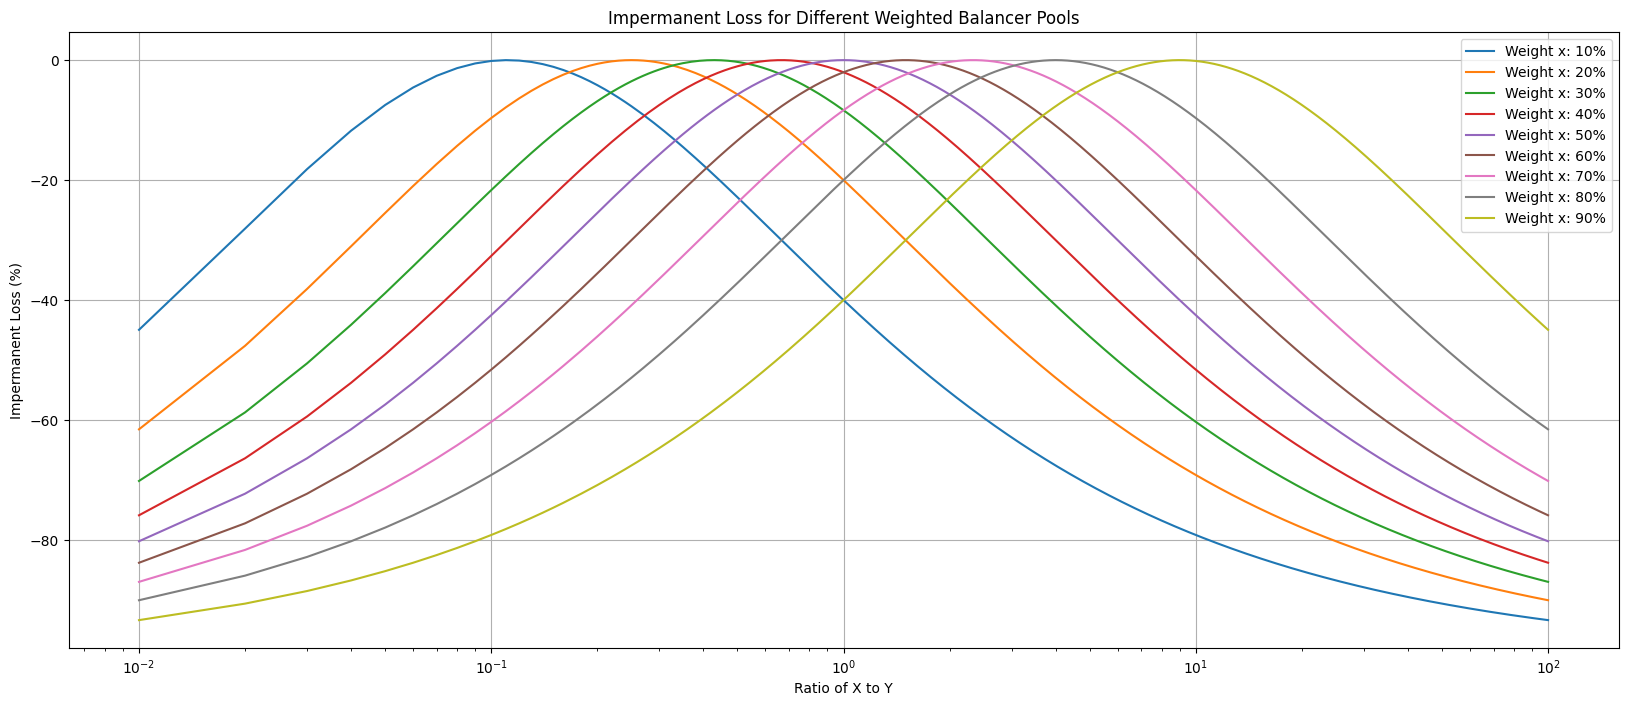

In [171]:
# Define weight configurations for Balancer pools
weights = np.arange(0.1, 1.0, 0.1)  # Weights

# Sample ratios from 0.01 to 10
ratios_balancer = np.linspace(0.01, 100, 10000)

# Calculate the impermanent loss for each weight configuration
plt.figure(figsize=(20, 8))

for weight_x in weights:
    weight_y = 1 - weight_x
    initial_price_ratio = weight_x / weight_y
    impermanent_losses_balancer = [calculate_impermanent_loss(r, initial_price_ratio) for r in ratios_balancer]
    plt.plot(ratios_balancer, impermanent_losses_balancer, label=f'Weight x: {weight_x*100:.0f}%')

plt.title('Impermanent Loss for Different Weighted Balancer Pools')
plt.xlabel('Ratio of X to Y')
plt.xscale('log')
plt.ylabel('Impermanent Loss (%)')
plt.grid(True)
plt.legend()
plt.show()